# Bike sharing demand forecast (on daily data)

Predict bike sharing demand as a function of seasonal and weather conditions.

Data origin:
- original full dataset (by hour, not used here): https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
- simplified dataset (by day, with some simple scaling): https://www.hds.utc.fr/~tdenoeux/dokuwiki/en/aec
    - description: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/exam_2019_ace_.pdf
    - data: https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/bike_sharing_day.csv.zip
    
Note that even if we are estimating a time serie, we are not using here a recurrent neural network as we assume the temporal dependence to be negligible (i.e. Y_t = f(X_t) alone).

In [36]:
using Pkg
function addIfNeeded(pkgs...)
    isinstalled(pkg::String) = any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
    [Pkg.add(pkg) for pkg in pkgs  if !isinstalled(pkg)]
end

addIfNeeded("DataFrames","CSV","StatsPlots","Distributions","DecisionTree")


using LinearAlgebra, Random, DataFrames, CSV, StatsPlots, BetaML.Trees, DecisionTree
import Distributions: Uniform

import Random:seed!
seed!(123)

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

In [2]:
# Data loading and cleaning..
baseDir = "assets/bikeSharingDemandForecast/"
data = CSV.File(joinpath(baseDir,"bike_sharing_day.csv"),delim=',') |> DataFrame
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,instant,366.0,1,366.0,731,,,Int64
2,dteday,,2011-01-01,,2012-12-31,731,,Date
3,season,2.49658,1,3.0,4,,,Int64
4,yr,0.500684,0,1.0,1,,,Int64
5,mnth,6.51984,1,7.0,12,,,Int64
6,holiday,0.0287278,0,0.0,1,,,Int64
7,weekday,2.99726,0,3.0,6,,,Int64
8,workingday,0.683995,0,1.0,1,,,Int64
9,weathersit,1.39535,1,1.0,3,,,Int64


In [3]:
x    = hcat(data[:,[:instant,:season,:yr,:mnth,:holiday,:weekday,:workingday,:weathersit,:temp,:atemp,:hum,:windspeed]])
y    = data[:,16] 

# Split the data in training/testing sets
ntrain    = Int64(round(size(x,1)*0.75))
nval      = Int64(round(size(x,1)*0.125))
ntest     = size(x,1) - (ntrain+nval)
xtrain    = x[1:ntrain,:]
ytrain    = y[1:ntrain]
xval      = x[(ntrain+1):(ntrain+nval),:]
yval      = y[(ntrain+1):(ntrain+nval)]
xtest     = x[ntrain+nval+1:end,:]
ytest     = y[ntrain+nval+1:end]

92-element Array{Int64,1}:
 6778
 4639
 7572
 7328
 8156
 7965
 3510
 5478
 6392
 7691
 7570
 7282
 7109
    ⋮
 4128
 3623
 1749
 1787
  920
 1013
  441
 2114
 3095
 1341
 1796
 2729

## Decision Trees

In [4]:
function findBestDepth(xtrain,ytrain,xval,yval,atteptedDepths)
    bestDepth = 1
    bestMre   = +Inf
    for ad in atteptedDepths
        myTree = buildTree(xtrain,ytrain, maxDepth=ad)
        ŷval   = Trees.predict(myTree, xval)
        mreVal = meanRelError(ŷval,yval)
        println("$ad : $mreVal")
        if mreVal < bestMre
            bestDepth = ad
            bestMre   = mreVal
        end
    end
    return (bestDepth, bestMre)
end

findBestDepth (generic function with 1 method)

In [5]:
bestDepth, bestMre = findBestDepth(xtrain,ytrain,xval,yval,1:20)

1 : 0.4127457010251527
2 : 0.27957279496923804
3 : 0.13440709867155343
4 : 0.11543645357414807
5 : 0.09823897896834381
6 : 0.11695408601762691
7 : 0.12455338425579428
8 : 0.12243694244101945
9 : 0.13086074249979696
10 : 0.11951022928177926
11 : 0.1382265316799392
12 : 0.13448560341131688
13 : 0.12432901697046307
14 : 0.13283779694928782
15 : 0.13616679801429252
16 : 0.1371506555310978
17 : 0.1299416584885876
18 : 0.13255170283975787
19 : 0.13302407473783337
20 : 0.13077140421334132


(5, 0.09823897896834381)

In [6]:
myTree = buildTree(xtrain,ytrain, maxDepth=bestDepth)

BetaML.Trees.DecisionNode{Float64,Int64}(BetaML.Trees.Question{Float64}(9, 0.433913), BetaML.Trees.DecisionNode{Int64,Int64}(BetaML.Trees.Question{Int64}(1, 433), BetaML.Trees.DecisionNode{Float64,Int64}(BetaML.Trees.Question{Float64}(11, 0.774583), BetaML.Trees.DecisionNode{Float64,Int64}(BetaML.Trees.Question{Float64}(12, 0.192783), BetaML.Trees.Leaf{Int64}(4108.4, 5), BetaML.Trees.Leaf{Int64}(5678.555555555556, 5), 4), BetaML.Trees.DecisionNode{Int64,Int64}(BetaML.Trees.Question{Int64}(1, 496), BetaML.Trees.Leaf{Int64}(6850.893617021276, 5), BetaML.Trees.Leaf{Int64}(6208.4390243902435, 5), 4), 3), BetaML.Trees.DecisionNode{Int64,Int64}(BetaML.Trees.Question{Int64}(8, 3), BetaML.Trees.DecisionNode{Int64,Int64}(BetaML.Trees.Question{Int64}(6, 3), BetaML.Trees.Leaf{Int64}(2099.0, 5), BetaML.Trees.Leaf{Int64}(2689.6666666666665, 5), 4), BetaML.Trees.DecisionNode{Int64,Int64}(BetaML.Trees.Question{Int64}(1, 110), BetaML.Trees.Leaf{Int64}(4479.5026455026455, 5), BetaML.Trees.Leaf{Int64}(3

In [7]:
ŷtrain = Trees.predict(myTree, xtrain)
ŷval   = Trees.predict(myTree, xval)
ŷtest  = Trees.predict(myTree, xtest)


92-element Array{Float64,1}:
 6850.893617021276
 5678.555555555556
 5678.555555555556
 6850.893617021276
 6850.893617021276
 6850.893617021276
 5225.7692307692305
 5225.7692307692305
 6850.893617021276
 6850.893617021276
 6850.893617021276
 6850.893617021276
 5225.7692307692305
    ⋮
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 2120.5
 5225.7692307692305
 2120.5
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305
 5225.7692307692305

In [8]:
mreTrain = meanRelError(ŷtrain,ytrain)

0.18366509363381545

In [9]:
mreVal = meanRelError(ŷval,yval)

0.09823897896834381

In [10]:
mreTest  = meanRelError(ŷtest,ytest)

2.421448822196853

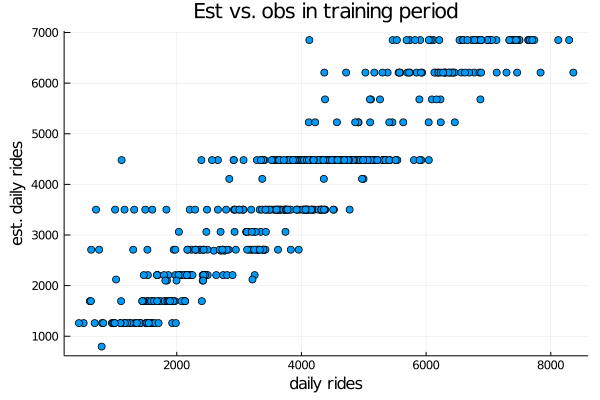

In [11]:
scatter(ytrain,ŷtrain,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

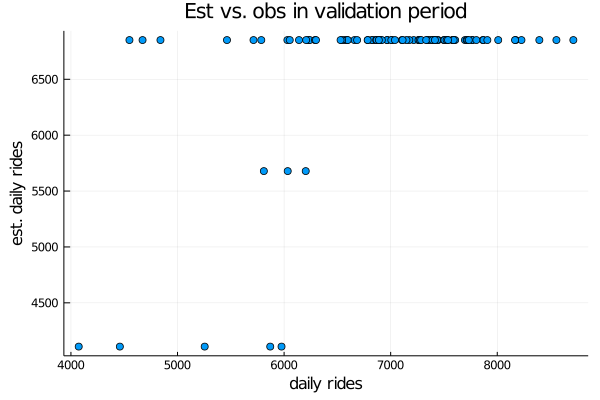

In [12]:
scatter(yval,ŷval,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

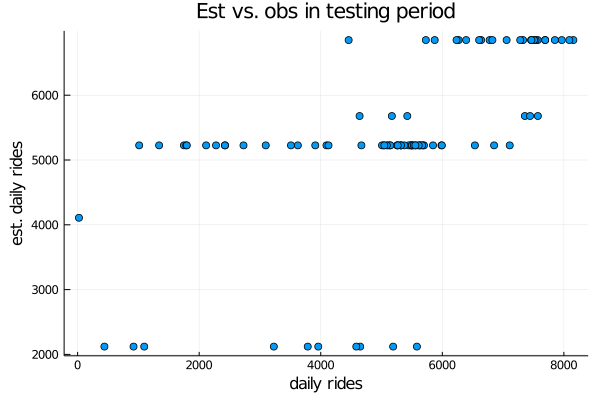

In [13]:
scatter(ytest,ŷtest,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

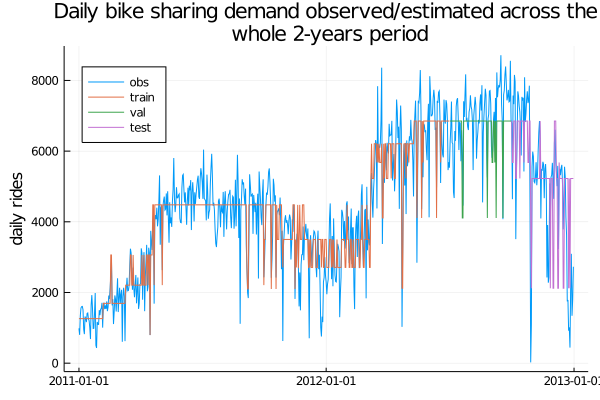

In [14]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

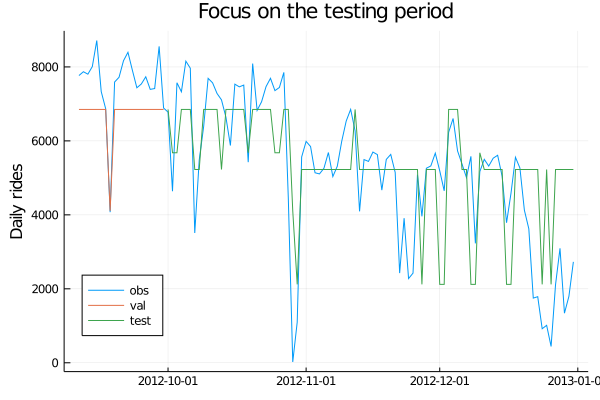

In [15]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")

## Random forest

In [16]:
function findBestDepth(xtrain,ytrain,xval,yval,atteptedDepths)
    bestDepth = 1
    bestMre   = +Inf
    for ad in atteptedDepths
        myForest = buildForest(xtrain,ytrain, 20, maxDepth=ad)[1]
        ŷval   = Trees.predict(myForest, xval)
        mreVal = meanRelError(ŷval,yval)
        println("$ad : $mreVal")
        if mreVal < bestMre
            bestDepth = ad
            bestMre   = mreVal
        end
    end
    return (bestDepth, bestMre)
end

findBestDepth (generic function with 1 method)

In [17]:
bestDepth, bestMre = findBestDepth(xtrain,ytrain,xval,yval,1:30)

1 : 0.409671150151936
2 : 0.26363194804703105
3 : 0.20487558477752493
4 : 0.1463119585237976
5 : 0.1512854938390643
6 : 0.12227102576979904
7 : 0.15853951663739552
8 : 0.1236301410049137
9 : 0.13496161473007692
10 : 0.16525691328144707
11 : 0.13024742646600962
12 : 0.13190528693135842
13 : 0.15437141883272135
14 : 0.12287203416606036
15 : 0.11424549219007923
16 : 0.12709443951902447
17 : 0.15975394381570954
18 : 0.1276605501705967
19 : 0.14008056314220316
20 : 0.10385687435726153
21 : 0.10882384157493537
22 : 0.13090104293631177
23 : 0.143057495773688
24 : 0.19332811109685144
25 : 0.14158150003532366
26 : 0.16337055916852036
27 : 0.1277880550439723
28 : 0.16930236930248513
29 : 0.11796614931544538
30 : 0.13133340979292094


(20, 0.10385687435726153)

In [84]:
myForestClassifier = buildForest(xtrain,ytrain, 30, maxDepth=bestDepth,β=50,oob=true)
myForest           = myForestClassifier[:forest]
treesWeights       = myForestClassifier[:weights]
oobError           = myForestClassifier[:oobError] # note: Here the oob reported is different than the testing error. Why? Because the division between training/validation a,d testing is not random, but has a temporal basis. It seems in this example that data in validation/testing feel a different pattern/variance than those in training

0.16134073996232803

In [85]:
ŷtrain = Trees.predict(myForest, xtrain)
ŷval   = Trees.predict(myForest, xval)
ŷtest  = Trees.predict(myForest, xtest)

92-element Array{Float64,1}:
 6226.0633333333335
 4383.994444444444
 5126.0
 6406.096666666666
 6817.366666666667
 6401.480476190477
 4740.33
 4114.718888888889
 5175.56111111111
 6103.185714285714
 6141.356084656085
 6108.756084656085
 4534.9
    ⋮
 4140.488148148148
 3711.491111111111
 3349.6
 3337.1666666666665
 3272.6944444444443
 3656.0944444444444
 3280.087777777778
 3476.061111111111
 3415.2333333333327
 3221.0444444444443
 3462.883333333333
 3408.7111111111108

In [86]:
ŷtrain2 = Trees.predict(myForest, xtrain, weights=treesWeights)
ŷval2   = Trees.predict(myForest, xval, weights=treesWeights)
ŷtest2  = Trees.predict(myForest, xtest, weights=treesWeights)

92-element Array{Float64,1}:
 6386.030648890343
 4206.628464470132
 5471.946344191387
 6428.033497767958
 7095.124864499326
 6415.709195781007
 4822.348274225941
 4515.815376284012
 5570.512442895989
 6439.672370399832
 6402.035158444041
 6424.736089563711
 4771.970450161029
    ⋮
 4518.030722095536
 3840.892639021779
 3477.429256297344
 3416.3563266863707
 3587.2388358741114
 4073.8395185686627
 3669.1064055200145
 3797.358711691287
 3650.337440934598
 3587.7109506748748
 3548.7796504628036
 3690.2940794014776

In [87]:
mreTrain = meanRelError(ŷtrain,ytrain)

0.06214543961398306

In [88]:
mreVal = meanRelError(ŷval,yval)

0.12585278707371944

In [89]:
mreTest  = meanRelError(ŷtest,ytest)

2.2804031892425685

In [90]:
mreTrain2 = meanRelError(ŷtrain2,ytrain)

0.0581188708777056

In [91]:
mreVal2 = meanRelError(ŷval2,yval)

0.11512688270835086

In [92]:
mreTest2  = meanRelError(ŷtest2,ytest)

2.2393727275540796

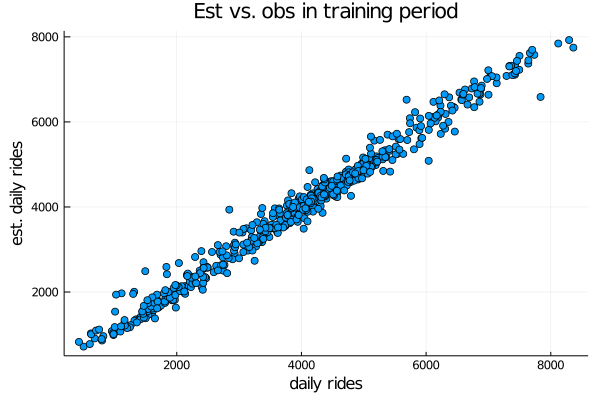

In [93]:
scatter(ytrain,ŷtrain2,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

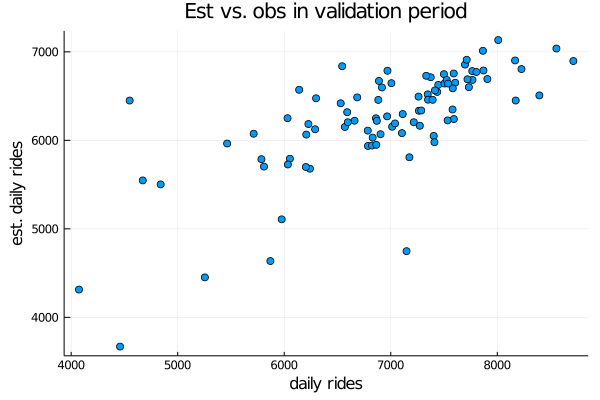

In [94]:
scatter(yval,ŷval2,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

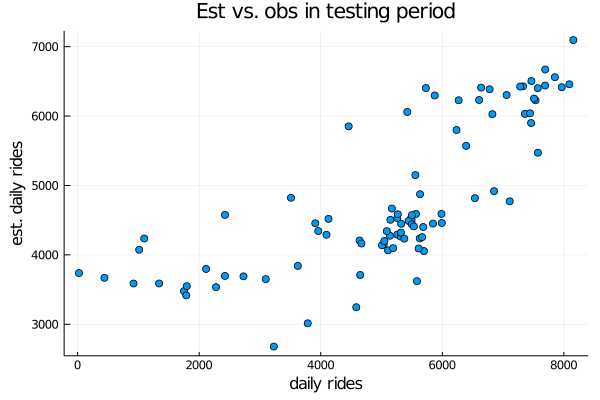

In [95]:
scatter(ytest,ŷtest2,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

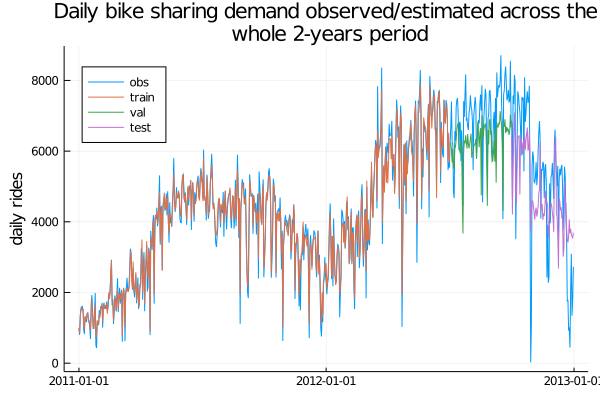

In [96]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain2,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval2, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest2)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

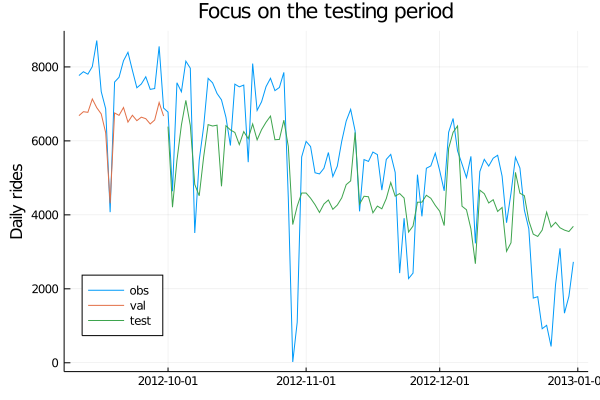

In [97]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")

# Comparison with DecisionTree package


In [80]:
n_subfeatures=-1; n_trees=30; partial_sampling=1.0; max_depth=-1
min_samples_leaf=1; min_samples_split=2; min_purity_increase=0.0; seed=3

model = build_forest(ytrain, convert(Matrix,xtrain),
                     n_subfeatures,
                     n_trees,
                     partial_sampling,
                     max_depth,
                     min_samples_leaf,
                     min_samples_split,
                     min_purity_increase;
                     rng = seed)

Ensemble of Decision Trees
Trees:      30
Avg Leaves: 344.9
Avg Depth:  10.3

In [81]:
ŷtrain           = apply_forest(model, convert(Matrix,xtrain))
mreTrain         = meanRelError(ŷtrain,ytrain)

0.0

In [82]:
ŷval             = apply_forest(model, convert(Matrix,xval))
mreTrain         = meanRelError(ŷval,yval)

0.16180468924594643

In [83]:
ŷtest            = apply_forest(model, convert(Matrix,xtest))
mreTrain         = meanRelError(ŷtest,ytest)

1.632596990925782

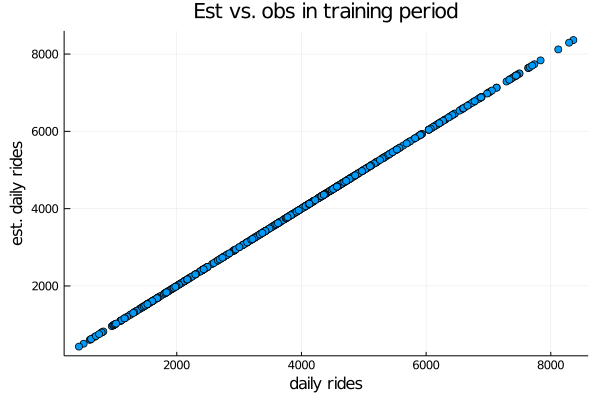

In [42]:
scatter(ytrain,ŷtrain,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in training period")

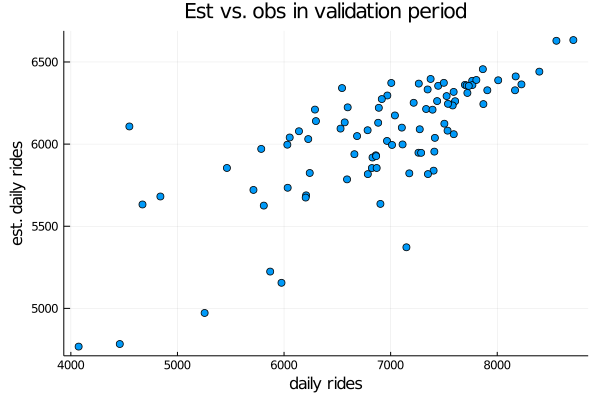

In [43]:
scatter(yval,ŷval,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in validation period")

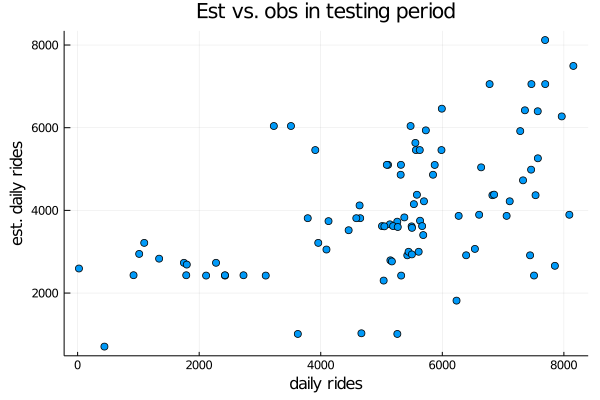

In [44]:
scatter(ytest,ŷtest,xlabel="daily rides",ylabel="est. daily rides",label=nothing,title="Est vs. obs in testing period")

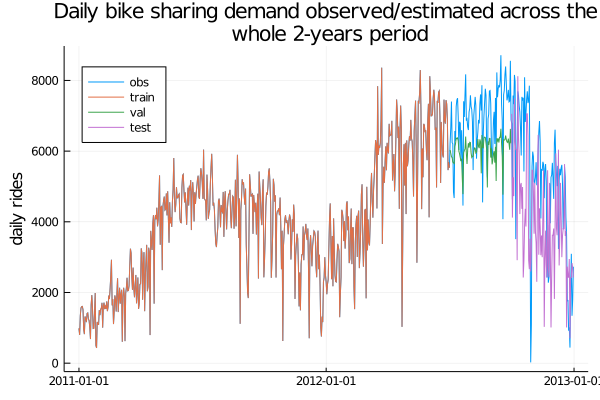

In [45]:
# Full period plot (2 years)
ŷtrainfull = vcat(ŷtrain,fill(missing,nval+ntest))
ŷvalfull = vcat(fill(missing,ntrain), ŷval, fill(missing,ntest))
ŷtestfull = vcat(fill(missing,ntrain+nval), ŷtest)
plot(data[:,:dteday],[data[:,:cnt] ŷtrainfull ŷvalfull ŷtestfull], label=["obs" "train" "val" "test"], legend=:topleft, ylabel="daily rides", title="Daily bike sharing demand observed/estimated across the\n whole 2-years period")

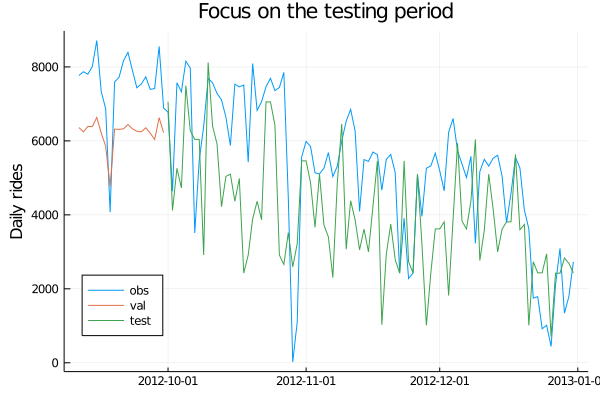

In [46]:
# Focus on testing data
stc = 620
endc = size(x,1)
plot(data[stc:endc,:dteday],[data[stc:endc,:cnt] ŷvalfull[stc:endc] ŷtestfull[stc:endc]], label=["obs" "val" "test"], legend=:bottomleft, ylabel="Daily rides", title="Focus on the testing period")